In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from  matplotlib.patches import Polygon
from IPython.display import Image
import imageio.v2
import csv

import tqdm as tqdm
import jax 
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_debug_nans", False)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from iLQR import iLQR, Path



In [3]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

Cost derivatives time:  1.276719093322754
Dynamics derivatives time:  0.4387192726135254
Backward pass time:  0.4806792736053467
forward time:  0.0008962154388427734 0.0007510185241699219 0.00023818016052246094
1.0 36.518932 68.21582 -31.696888 1.0
Update from  68.21582  to  36.518932 reg:  1.0 alpha: 1.000 2.920
Cost derivatives time:  0.00041604042053222656
Dynamics derivatives time:  0.0007905960083007812
Backward pass time:  9.107589721679688e-05
forward time:  0.0008082389831542969 0.0004639625549316406 0.0001800060272216797
1.0 24.27738 36.518932 -12.241552 0.2
Update from  36.518932  to  24.27738 reg:  0.2 alpha: 1.000 2.923
Cost derivatives time:  0.0002560615539550781
Dynamics derivatives time:  0.0008428096771240234
Backward pass time:  7.891654968261719e-05
forward time:  0.0007522106170654297 0.00044465065002441406 0.00017142295837402344
1.0 22.97103 24.27738 -1.3063507 0.04
Update from  24.27738  to  22.97103 reg:  0.04 alpha: 1.000 2.926
Cost derivatives time:  0.00023818

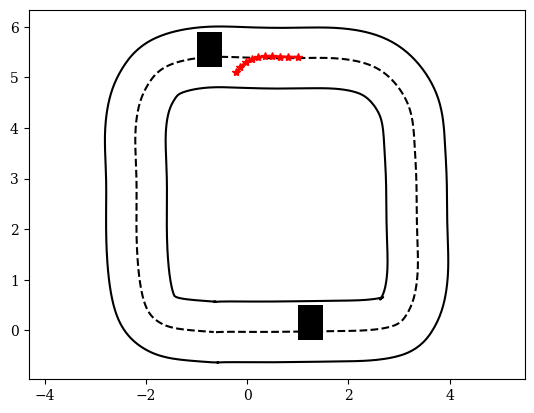

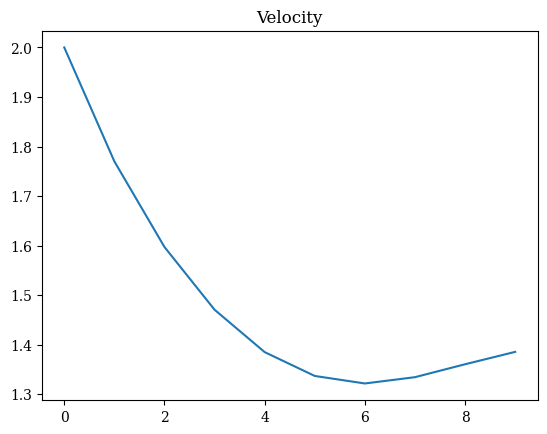

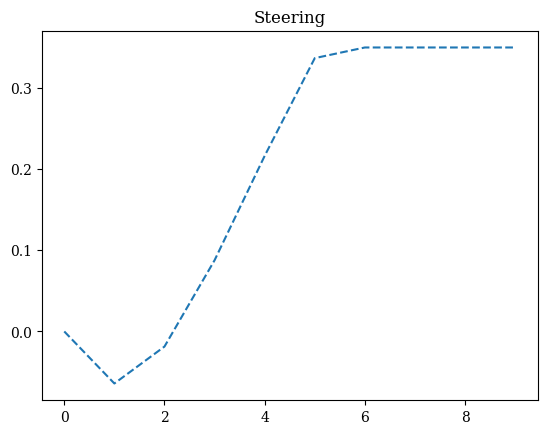

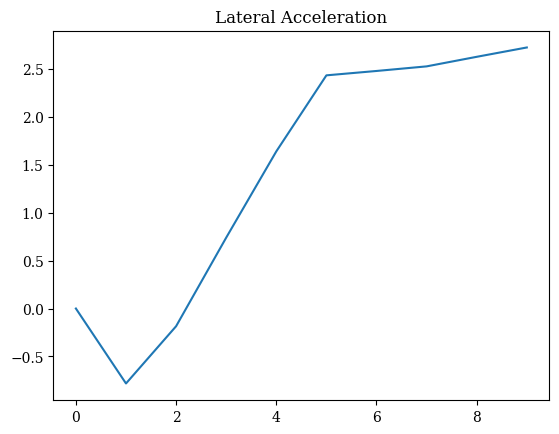

In [25]:
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)
config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR()#config_file)
# # make some obstacles
# obs1 = np.array([[-1, -1, -0, -0], [5.2, 6.0, 6.0, 5.2]]).T
obs1 = np.array([[-1, -1, -0.5, -0.5], [5.2, 5.9, 5.9, 5.2]]).T
obs2 = np.array([[1, 1, 1.5, 1.5], [-0.2, 0.5, 0.5, -0.2]]).T
obs_list = [[obs1 for _ in range(10)]]#, [obs2 for _ in range(10)]]
solver.update_obstacles(obs_list)
solver.update_path(path)

x_cur = np.array([1, 5.4, 2, 3.14, 0])
plan = solver.plan(x_cur)

path.plot_track()
path.plot_track_center()
plt.plot(plan['states'][0, :], plan['states'][1, :], 'r-*', linewidth=2)

p = Polygon(obs1, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

p = Polygon(obs2, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

print(plan['status'])

plt.figure()
a = plan['states'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['states'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['states'][2, :]**2 / 0.257 * np.tan(plan['states'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')

print(plan['t_process'])


In [10]:
True | False

True

In [ ]:
x_cur = np.array([0., 0., 2., 0., 0.])  # Initial state.

# Load ILQR
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)

config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR() #(config_file)
solver.update_path(path)

obs1 = np.array([[-1, -1, -0.5, -0.5], [5.3, 5.8, 5.8, 5.3]]).T
obs2 = np.array([[1, 1.25, 1.5, 1.5, 1.25, 1], [5.8, 5.4, 5.8 , 6.0, 6.2, 6.0]]).T
obs3 = np.array([[2.5, 2.5, 2, 2], [-0, 0.5, 0.5, -0]]).T
# obs4 = np.array([[-200, -200, -1.5, -1.5], [0.5, 1, 1, 0.5]]).T
obs_list = [[obs1 for _ in range(10)], 
            [obs2 for _ in range(10)],
            [obs3 for _ in range(10)]]
            # [obs4 for _ in range(10)]]
solver.update_obstacles(obs_list)

# define some parameters
n = 10
itr_receding = 100
init_control = np.zeros((2, n))
fig_prog_folder = 'fig/'
! mkdir -p $fig_prog_folder

state_history = np.zeros((5,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    
    plan = solver.plan(x_cur, init_control)
    states = plan['states']
    controls = plan['controls']
    x_cur = states[:,1]
    state_history[:,i]  = x_cur
    init_control[:,:-1] = controls[:,1:]
    pbar.set_description(f"iLQR takes : {plan['t_process']:.2f} sec']")
    t_process[i] = plan['t_process']
    # plot
    plt.clf()
    path.plot_track()
    p = Polygon(obs1, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs2, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs3, facecolor = 'k')
    plt.gca().add_patch(p)

    # p = Polygon(obs4, facecolor = 'k')
    # plt.gca().add_patch(p)
    
    sc = plt.scatter(
        state_history[0, :i], state_history[1, :i], s=24,
        c=state_history[2, :i], cmap=cm.jet, vmin=0, vmax=5,
        edgecolor='none', marker='o'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(r"velocity [$m/s$]", size=20)
    
    plt.plot(states[0, :], states[1, :], 'r', linewidth=2)
    plt.axis('equal')
    plt.savefig(os.path.join(fig_prog_folder, str(i)+".png"), dpi=200)
plt.close('All')

gif_path = os.path.join(fig_prog_folder, 'rollout.gif')
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(itr_receding):
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)

plt.figure()
plt.plot(state_history[2,:])
plt.title('Velocity')


plt.figure()
a = state_history[2, :]**2 / 0.257 * np.tan(state_history[-1, :])
plt.plot(a)

plt.figure()
plt.plot(t_process)



In [ ]:
a = np.random.randn(2,20)
b = np.zeros_like(a)

i=7
b[:,:(20-i)] = a[:,i:]
b